In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tomo2mesh.projects.eaton.rw_utils_ae import read_raw_data_1X, save_path
from tomo2mesh.projects.eaton.recon import recon_slice, recon_all
from tomo2mesh.misc import viewer
from tomo2mesh.misc.voxel_processing import cylindrical_mask, modified_autocontrast, TimerGPU, TimerCPU
import cupy as cp

In [2]:
projs, theta, center, dark, flat = read_raw_data_1X("TCRP3_AMTitan_200umlht", "146")
pixel_size = 3.13
dust_thresh = 2

In [3]:
center

1159.5

In [4]:
projs = np.array(projs, dtype = np.float32)
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)

In [5]:
t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)
#FBP
t_gpu.tic()
V_rec = recon_all(projs, theta, center, 32, dark, flat, pixel_size, outlier_removal = True) 
t_rec = t_gpu.toc('RECONSTRUCTION')

100%|███████████████████████████████████████████| 48/48 [04:06<00:00,  5.13s/it]

	TIME: RECONSTRUCTION 246.02 secs


In [6]:
V_rec_adj = np.clip(V_rec, *modified_autocontrast(V_rec[::4,::4,::4], s = 0.01))

In [7]:
from tomo2mesh.projects.eaton.void_mapping import local_otsu

In [8]:
timer = TimerCPU("secs")
timer.tic()
V_seg = local_otsu(V_rec, p_size = 384)
timer.toc('BINARIZATION')

	TIME: BINARIZATION 84.54 secs


84.54150605201721

In [9]:
cylindrical_mask(V_seg, 1, mask_val = 0)
cylindrical_mask(V_rec_adj, 1, mask_val = V_rec_adj[::4,::4,::4].min())

In [10]:
imx = viewer.get_orthoplanes(vol = V_rec_adj)
imb = viewer.get_orthoplanes(vol = V_seg)

<AxesSubplot:>

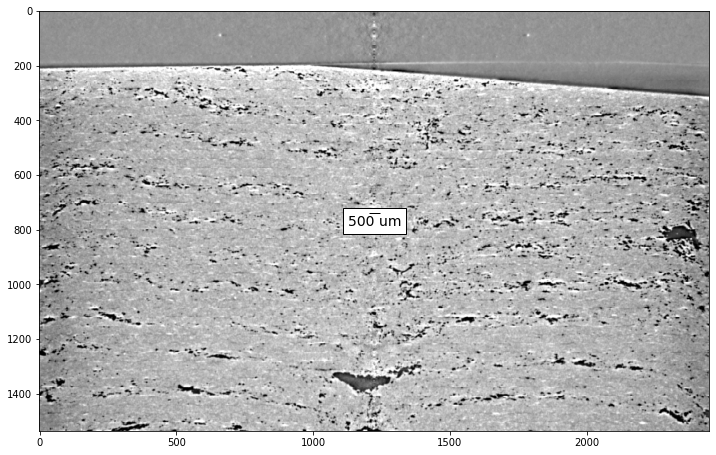

In [11]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
ax.imshow(imx[1], cmap = 'gray')
viewer.add_scalebar(ax, 500, 3.13*4, fontsize = 14, loc = 'center')
# ax.axis('off')

(-0.5, 2447.5, 2447.5, -0.5)

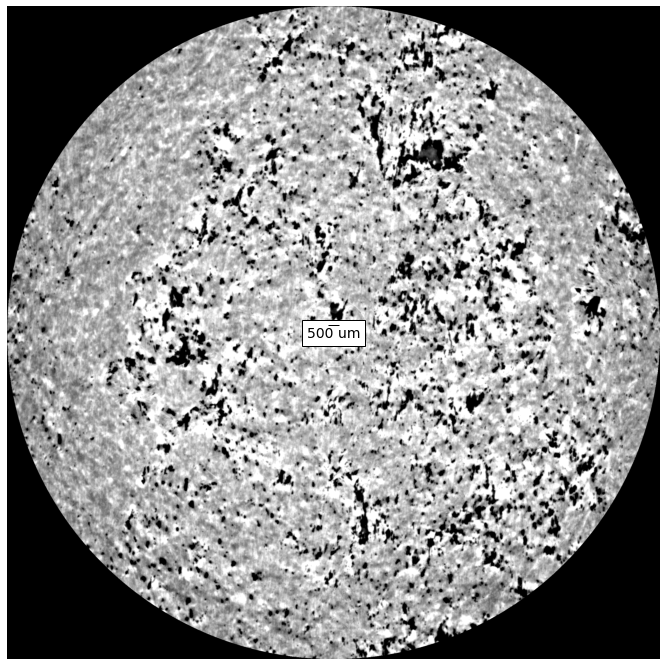

In [12]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
ax.imshow(imx[0], cmap = 'gray')
viewer.add_scalebar(ax, 500, 3.13*4, fontsize = 14, loc = 'center')
ax.axis('off')

(-0.5, 2447.5, 2447.5, -0.5)

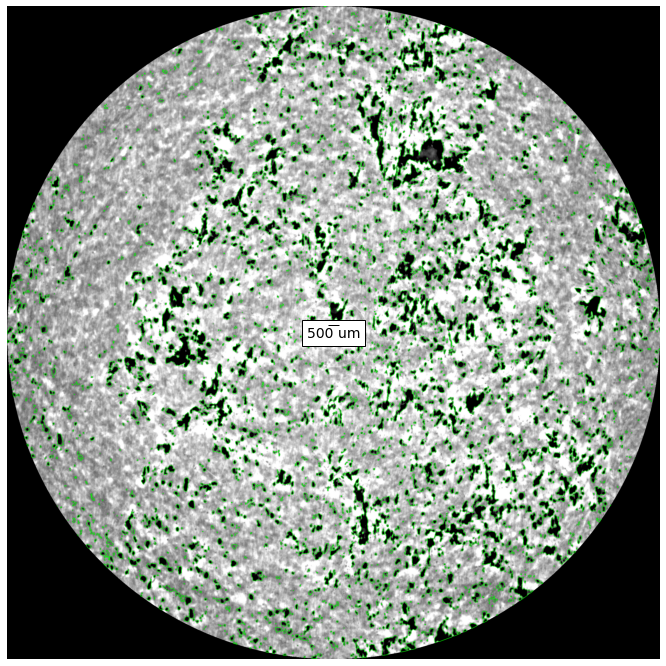

In [13]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
viewer.edge_plot(imx[0], imb[0], ax)
viewer.add_scalebar(ax, 500, 3.13*4, fontsize = 14, loc = 'center')
ax.axis('off')

NameError: name 'imgs' is not defined

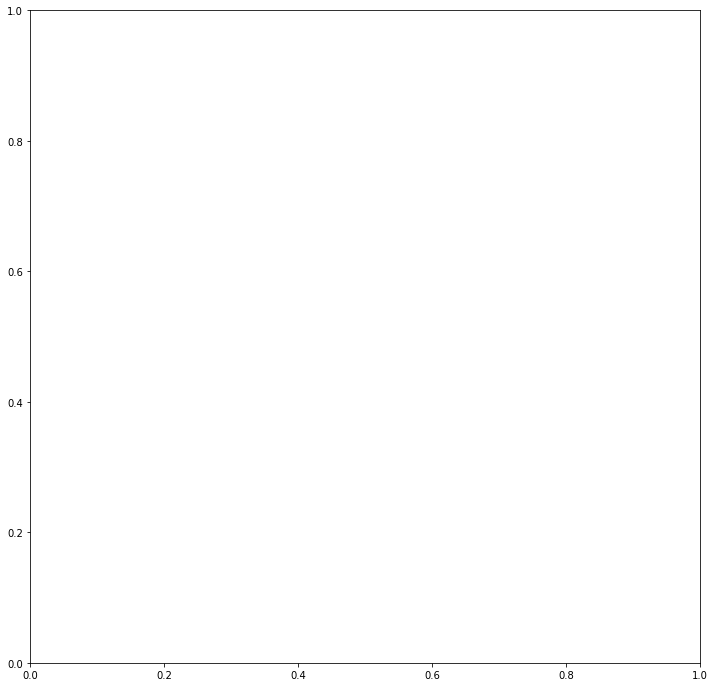

In [14]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
ax.imshow(imgs[2], cmap = 'gray')
viewer.add_scalebar(ax, 500, 3.13*4, fontsize = 14, loc = 'center')
# ax.axis('off')

In [ ]:
z_var = np.mean(V, axis = (1,2))
plt.plot(z_var)
plt.xlim([0,50])
plt.xlabel('pixels in b = 4')
plt.ylabel('mean intensity per slice')